Tutorial: Calculating Spectra
=================
*01/2021: updated to pyGDM v1.1+*

This is an example how to calculate spectra from pyGDM simulations.

We start again by loading the pyGDM modules that we are going to use:

In [1]:
## --- Load the pyGDM modules 
from pyGDM2 import structures
from pyGDM2 import materials
from pyGDM2 import fields
from pyGDM2 import propagators
from pyGDM2 import core
from pyGDM2 import linear
from pyGDM2 import visu
from pyGDM2 import tools

## --- we will use numpy as well
import numpy as np

Setting up the simulation
----------------------------

In [2]:
## --- we will use a sphere, here R=50nm and this time made of gold
## --- for demonstration purpose we will discretize rather coarse
step = 10
geometry = structures.sphere(step, R=5, mesh='hex')
material = materials.gold()
struct = structures.struct(step, geometry, material)


## --- we use again a plane wave
field_generator = fields.plane_wave
## --- this time however, we want to calculate a whole spectrum.
## --- we use numpy's *linspace* to get a list of linearly 
## --- spaced wavelengths
wavelengths = np.linspace(400, 800, 41)
## --- let's furthermore simulate three linear polarizations at normal incidence
kwargs = dict(theta=[0, 45, 90], inc_angle=180)

efield = fields.efield(field_generator, 
               wavelengths=wavelengths, kwargs=kwargs)

## --- vacuum environment
n1 = n2 = 1.0
dyads = propagators.DyadsQuasistatic123(n1=n1, n2=n2)


## --- define the numerical experiment
sim = core.simulation(struct, efield, dyads)

structure initialization - automatic mesh detection: hex
structure initialization - consistency check: 853/853 dipoles valid


Run the simulation
--------------------

**Note:** The output of *scatter* can be turned off by passing "verbose=False"

In [3]:
## --- run the simulation
sim.scatter()

/home/hans/.local/lib/python3.8/site-packages/numba/core/dispatcher.py:241: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'VersionConflict((scipy 1.7.1 (/home/hans/.local/lib/python3.8/site-packages), Requirement.parse('scipy<=1.6.2,>=0.16')))'.
  entrypoints.init_all()


timing for wl=400.00nm - setup: EE 1610.1ms, inv.: 318.9ms, repropa.: 545.4ms (3 field configs), tot: 2474.7ms
timing for wl=410.00nm - setup: EE 49.7ms, inv.: 285.6ms, repropa.: 72.7ms (3 field configs), tot: 408.3ms
timing for wl=420.00nm - setup: EE 51.1ms, inv.: 303.3ms, repropa.: 73.2ms (3 field configs), tot: 428.0ms
timing for wl=430.00nm - setup: EE 47.8ms, inv.: 287.6ms, repropa.: 74.2ms (3 field configs), tot: 410.0ms
timing for wl=440.00nm - setup: EE 44.4ms, inv.: 307.2ms, repropa.: 73.7ms (3 field configs), tot: 425.4ms
timing for wl=450.00nm - setup: EE 46.2ms, inv.: 287.7ms, repropa.: 73.5ms (3 field configs), tot: 407.8ms
timing for wl=460.00nm - setup: EE 47.0ms, inv.: 325.8ms, repropa.: 72.1ms (3 field configs), tot: 445.0ms
timing for wl=470.00nm - setup: EE 52.8ms, inv.: 310.5ms, repropa.: 70.2ms (3 field configs), tot: 433.8ms
timing for wl=480.00nm - setup: EE 49.4ms, inv.: 286.1ms, repropa.: 71.8ms (3 field configs), tot: 407.4ms
timing for wl=490.00nm - setup: E

1

Short comment: Structure of the simulation results
-----------------------------------------------------

**E**, as well as the *simulation* instance (**sim.E**) now contain the self-consistent electric field inside the nano-particle for each incident field configuration.
**sim.E** is a list of lists. Each element of **sim.E** contains as first entry the simulation configuration encoded as a dictionary with keys cooresponding to the parameters taken by the field-generator (in our case this was **fields.planewave**). 
The second entry is a list of complex 3-tuples (Ex, Ey, Ez), corresponding to the complex electric field at the according meshpoint (defined by **sim.structure.geometry**).

Let's have a look:

In [4]:
print("fieldindex '0' :", sim.E[0][0])
print("fieldindex '1' :", sim.E[1][0])
print("fieldindex '17':", sim.E[17][0])
print("Shape of field :", sim.E[17][1].shape)
print("     (--> (Number of meshopints, E_X;E_Y;E_Z) )")

fieldindex '0' : {'inc_angle': 180, 'theta': 0, 'wavelength': 400.0}
fieldindex '1' : {'inc_angle': 180, 'theta': 45, 'wavelength': 400.0}
fieldindex '17': {'inc_angle': 180, 'theta': 90, 'wavelength': 450.0}
Shape of field : (853, 3)
     (--> (Number of meshopints, E_X;E_Y;E_Z) )


If we search a particular field-configuration, the fieldindex notation is probably not very intuitive since it is a sequentiel number, specifying one within all possible permutations of field-parameters.

To find the closest available configuration for specific search-values, one can use:

In [5]:
search_dict = dict(theta=80, inc_angle=180, wavelength=750)
idx = tools.get_closest_field_index(sim, search_dict)

print('closest match: index', idx)
print('    --> dict:', sim.E[idx][0])

closest match: index 107
    --> dict: {'inc_angle': 180, 'theta': 90, 'wavelength': 750.0}


Evaluating the simulation
-----------------------------

The field inside the particle might be interesting to know, but since it is  hardly accessible in experiment, usually more easily accessible physical quantities are derived from the internal fields.

Let's calculate the extinction, scattering and absorption corss-section for the above field configuration:

**Note:** all high-level evaluation function like provided by the *linear* module take (at least) the *simulation* object and a fieldindex as first two parameters.

In [6]:
a_ext, a_scat, a_abs = linear.extinct(sim, idx)
print("cross sections:")
print("    extinction = {:.2f} nm^2".format(float(a_ext)))
print("    scattering = {:.2f} nm^2".format(float(a_scat)))
print("    absorption = {:.2f} nm^2".format(float(a_abs)))

cross sections:
    extinction = 3604.96 nm^2
    scattering = 1762.54 nm^2
    absorption = 1842.42 nm^2


Calculating a spectrum
-----------------------------

To calculate a full spectrum of some physical quantity like the above corss sections, we now simply need to evaluate all the fields composing a spectrum.
Because again, it is not evident, which fieldindices correspond to a spectrum for, let's say, *X*-polarization (theta=0), there are helper-functions for spectrum-calculation, provided by pyGDM:

In [7]:
## get all simulated configurations, each corresponding to a spectrum
field_kwargs = tools.get_possible_field_params_spectra(sim)
for i, conf in enumerate(field_kwargs):
    print("config", i, ":", conf)

config 0 : {'inc_angle': 180, 'theta': 0}
config 1 : {'inc_angle': 180, 'theta': 45}
config 2 : {'inc_angle': 180, 'theta': 90}


Now let's calculate and plot cross-sections for the spectrum "config 0":

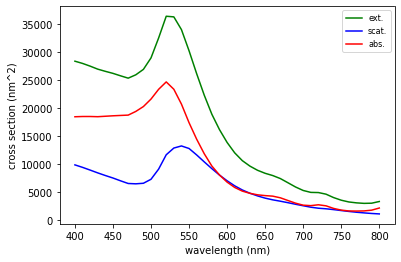

In [8]:
## --- calculate a spectrum using a specific evaluation function.
## --- We will use the spectrum with theta=0 on "linear.extinct":
## Note that instead of 'field_kwargs[config_idx]' we could also pass
## just the index of the configuration `0` (--> config_idx).
config_idx = 0
wl, spectrum = tools.calculate_spectrum(sim, 
                    field_kwargs[config_idx], linear.extinct)

## --- linear.extinct returns 3-tuples, "spectrum" therefore consists
## --- of an array of 3-tuples, corresponding to extinction, 
## --- scattering and absorption.

import matplotlib.pyplot as plt

plt.plot(wl, spectrum.T[0], 'g-', label='ext.')
plt.plot(wl, spectrum.T[1], 'b-', label='scat.')
plt.plot(wl, spectrum.T[2], 'r-', label='abs.')

plt.xlabel("wavelength (nm)")
plt.ylabel("cross section (nm^2)")
plt.legend(loc='best', fontsize=8)

plt.show()

We can use any of the other evaluation functions to calculate a spectrum:

In [9]:
## --- total deposited heat in particle
wl, spec_heat = tools.calculate_spectrum(sim, 
          field_kwargs[config_idx], linear.heat)


## --- temperature increase at [0,0,200] (nm)
wl, spec_temp = tools.calculate_spectrum(sim, 
          field_kwargs[config_idx], linear.temperature, r_probe=[0,0,200])


## --- nearfield at [0,0,200] (nm)
wl, spec_nf = tools.calculate_spectrum(sim, 
          field_kwargs[config_idx], linear.nearfield, r_probe=[0,0,200])

## --- calculate the nearfield intensity (sum|i=x,y,z  abs(E_i)^2)
spec_nf_intensity = np.sum(np.abs(spec_nf[:,1,0,3:])**2, axis=1)
## indices [:,1,0,3:] denote [a,b,c,d]: 
##         - a: wavelengths (':' --> use all)
##         - b: returned field types ('1' --> total Efield (E0 + Escat))
##         - c: evaluated positions in *r_probe* ('0' --> first of one pos.)
##         - d: field list elements [x,y,z,Ex,Ey,Ez] 
##              ('3:' --> only use field components, not the coordinates)
##
## please note also that the incident field amplitude of the plane_wave is 
## set to 1 so the intensity is implicitly normalized to the incident field

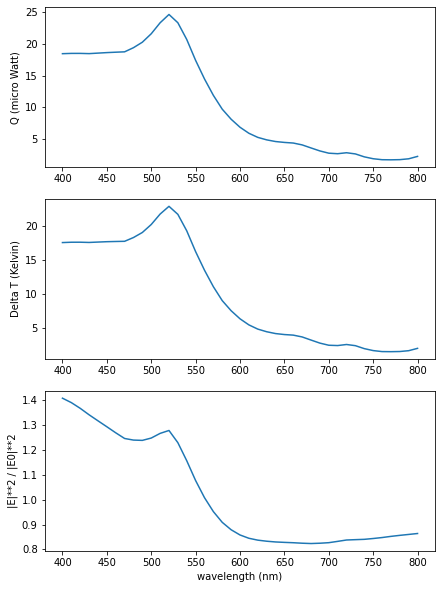

In [10]:
## --- plot the spectra
plt.figure(figsize=(7,10))
plt.subplot(311)
plt.plot(wl, spec_heat/1E3)
plt.ylabel("Q (micro Watt)")

plt.subplot(312)
plt.plot(wl, spec_temp)
plt.ylabel("Delta T (Kelvin)")

plt.subplot(313)
plt.plot(wl, spec_nf_intensity)
plt.xlabel("wavelength (nm)")
plt.ylabel("|E|**2 / |E0|**2")

plt.show()

Finally, let's compare the three different polarizations we simulated. Since we calculated a sphere in vaccum, they should result in an identical response. 

Let's check the scattering spectra:

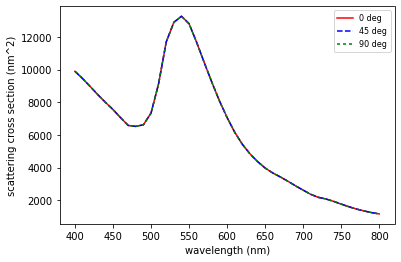

In [11]:
wl, spec0 = tools.calculate_spectrum(sim, 
                    field_kwargs[0], linear.extinct)
wl, spec45 = tools.calculate_spectrum(sim, 
                    field_kwargs[1], linear.extinct)
wl, spec90 = tools.calculate_spectrum(sim, 
                    field_kwargs[2], linear.extinct)


import matplotlib.pyplot as plt

plt.plot(wl, spec0.T[1], 'r-', label='0 deg')
plt.plot(wl, spec45.T[1], 'b--', label='45 deg')
plt.plot(wl, spec45.T[1], 'g', dashes=[2,2], label='90 deg')

plt.xlabel("wavelength (nm)")
plt.ylabel("scattering cross section (nm^2)")
plt.legend(loc='best', fontsize=8)

plt.show()

The curves are overlapping. Good!

Simulation with polarization dependent response
-----------------------------------

Finally, let's try what happens if we use a non-symmetric structure which should have an optical response that varies with the incident polarization angle.

In [12]:
## --- rectangular wire with otherwise same configuration as above
geometry = structures.rect_wire(step, L=20, W=8, H=3)
struct = structures.struct(step, geometry, material)

## --- same spectrum as above but with a lot more polarization angles
kwargs = dict(theta=np.linspace(0, 90, 31), inc_angle=180)
efield = fields.efield(field_generator, 
               wavelengths=wavelengths, kwargs=kwargs)

## --- define the numerical experiment
sim_polarizations = core.simulation(struct, efield, dyads)

## --- run the simulation
sim_polarizations.scatter()

structure initialization - automatic mesh detection: cube
structure initialization - consistency check: 480/480 dipoles valid
timing for wl=400.00nm - setup: EE 24.2ms, inv.: 97.6ms, repropa.: 365.5ms (31 field configs), tot: 487.5ms
timing for wl=410.00nm - setup: EE 22.4ms, inv.: 88.0ms, repropa.: 367.5ms (31 field configs), tot: 478.1ms
timing for wl=420.00nm - setup: EE 28.7ms, inv.: 206.2ms, repropa.: 365.8ms (31 field configs), tot: 601.0ms
timing for wl=430.00nm - setup: EE 22.5ms, inv.: 117.6ms, repropa.: 361.9ms (31 field configs), tot: 502.1ms
timing for wl=440.00nm - setup: EE 23.1ms, inv.: 89.7ms, repropa.: 360.6ms (31 field configs), tot: 473.5ms
timing for wl=450.00nm - setup: EE 22.4ms, inv.: 88.7ms, repropa.: 360.3ms (31 field configs), tot: 471.6ms
timing for wl=460.00nm - setup: EE 23.0ms, inv.: 89.1ms, repropa.: 360.6ms (31 field configs), tot: 472.9ms
timing for wl=470.00nm - setup: EE 22.4ms, inv.: 90.8ms, repropa.: 386.4ms (31 field configs), tot: 499.8ms
timing f

1

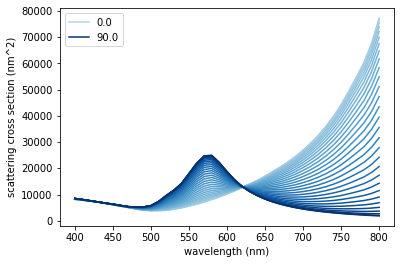

In [13]:
## --- get the spectra-configurations
spectra_kwargs = tools.get_possible_field_params_spectra(sim_polarizations)

## --- plot scattering for all configs (--> diff. polarizations)
colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(spectra_kwargs)))
for i, field_kwargs in enumerate(spectra_kwargs):
    ## here we call `calculate_spectrum` just using the spectrum's index (--> `i`)
    wl, spec0 = tools.calculate_spectrum(sim_polarizations, i, linear.extinct)

    lab = ''
    if i in [0, len(spectra_kwargs)/2, len(spectra_kwargs)-1]:
        lab = field_kwargs['theta']
    plt.plot(wl, spec0.T[1], color=colors[i], label=lab)

plt.legend(loc='best')
plt.xlabel("wavelength (nm)")
plt.ylabel("scattering cross section (nm^2)")

plt.show()

The different shades of blue indicate the different incident linear polarizations from light blue (zero degrees, parallel to the rod) to dark blue (90 degrees, perpendicular to the rod). We actually found two isosbestic points, where the response is independent of the polarization (around 500nm and around 600nm).